### Uncertainty Tutorial | Model Profiling | LeNet

#### Step 1 - Import relevant modules

In [1]:
from __future__ import division
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
torch.cuda.set_device(1)
from torchsummary import summary
from untangle import UntangleAI
untangle_ai = UntangleAI()

#### Step 2 - Define transforms to be applied to each input image

In [2]:
class MyContrastTransform:

    def __init__(self):
        pass

    def __call__(self, x):
        return TF.adjust_contrast(x, 5)

class MyNegativeTransform:
    
    def __init__(self):
        pass
    
    def __call__(self,x):
        return torch.ones(x.shape)-x

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        MyContrastTransform(),
        transforms.ToTensor(),
        MyNegativeTransform(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### Step 3 (optional) - Display input samples

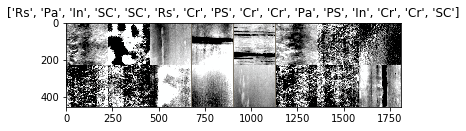

In [3]:
dataroot = 'NEU-CLS_New'
image_datasets = {x: datasets.ImageFolder(os.path.join(dataroot, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
class_names = image_datasets['train'].classes

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#### Step 4 - Define the pytorch model

In [4]:
from collections import OrderedDict
class Modified_LeNet5(nn.Module):
    def __init__(self):
        super(Modified_LeNet5, self).__init__()
        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(3, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120*49*49,84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 6)),
        ]))
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

#### Step 5 - Define uncertainty arguments and set the module to eval phase

In [16]:
class Args:
    mname = 'lenet_neu'
    batch_size = 128
    num_classes = 6
    img_size = (3,224,224)
    input_tensor = torch.randn(1,3,224,224) # provide your own input tensor
    data_class = None # or `None` to model uncertainty for all classes
    mode = 'eval_point' # one of `model`, `eval_point`, `rank`
    metric = 'prob' # for future additions. Current default set to `prob`
    sigmoid_node = False # if True, model is assumed to have a single output node with Sigmoid

args = Args()
model_ft = Modified_LeNet5()
model_ft = model_ft.eval()
model_ckpt_path = "NEU_Surface_Crack_full_Modified_Lenet_with_contrast_enhancement_and_neg_level5.pth"
if (torch.cuda.is_available()):
    ckpt = torch.load(model_ckpt_path)
    model_ft.load_state_dict(ckpt)
    model_ft = model_ft.cuda()
else:
    ckpt = torch.load(model_ckpt_path, map_location='cpu')
    model_ft.load_state_dict(ckpt)

keys = [str(item) for item in range(args.num_classes)]
ID2Name_Map = dict(zip(keys, keys)) # backward compatibility to existing codebase

#### Step 6 - Estimate model uncertainty for each target class 

In [6]:
dataroot = 'NEU-CLS_New/train'
module_path = os.path.realpath('.')
model_uncrt_data_path = os.path.join(module_path, 'model_uncrt_data/')
uncertainty_store_path = os.path.join(model_uncrt_data_path, '{}_uncertainty'.format(args.mname))
def train_loader_fun(class_i):
    loader = untangle_ai.load_from_dir_per_class(dataroot, data_class=class_i, batch_size=128, transform=data_transforms['train'], shuffle=False,
                                get_paths=False)
    return(loader)

device = torch.device("cuda")
model_ft.to(device)
untangle_ai.model_uncertainty(model_ft, uncertainty_store_path, train_loader_fun, args)

  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `0`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `0`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `1`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `1`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `2`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `2`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `3`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `3`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `4`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `4`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating uncertainty for class: `5`


  0%|          | 0/2 [00:00<?, ?it/s]

Estimating neighbour statistics for class: `5`


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


#### Step 7 - GPU profile | Inference only

In [7]:
device = torch.device("cuda")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)

In [8]:
%%timeit
model_ft(input_tensor)

3.95 ms ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Step 8 - CPU profile | Inference only

In [9]:
device = torch.device("cpu")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)

In [10]:
%%timeit
model_ft(input_tensor)

7.87 ms ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Step 9 - GPU profile | Single point uncertainty

In [11]:
device = torch.device("cuda")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

100%|██████████| 5/5 [00:00<00:00, 1124.96it/s]

computing internal statistics...


[{'c2c': 51.80022430419922,
  'decision': 'uncertain',
  'inclination': (71, 4, 0),
  'p_c1': 18.99761390686035,
  'p_c2': 46.76469039916992,
  'pred': 'NA',
  'score': 0.9999999999991273,
  'topk_idx': [4, 0],
  'topk_logits': [10.095089, 9.9374075],
  'topk_prob': [0.53930604, 0.46063304]}]

In [12]:
%%timeit
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

90.3 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Step 10 - CPU profile | Single point uncertainty

In [13]:
device = torch.device("cpu")
input_tensor = args.input_tensor.to(device)
model_ft = model_ft.to(device)
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

[{'c2c': 51.80022430419922,
  'decision': 'uncertain',
  'inclination': (71, 4, 0),
  'p_c1': 18.997615814208984,
  'p_c2': 46.76469039916992,
  'pred': 'NA',
  'score': 0.9999999999991273,
  'topk_idx': [4, 0],
  'topk_logits': [10.095088, 9.937409],
  'topk_prob': [0.5393053, 0.46063375]}]

In [14]:
%%timeit
untangle_ai.eval_point(model_ft, input_tensor, uncertainty_store_path, ID2Name_Map, args)

207 ms ± 1.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Step 11 - Model memory consumption

In [15]:
device = torch.device("cuda")
model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 220, 220]             456
              ReLU-2          [-1, 6, 220, 220]               0
         MaxPool2d-3          [-1, 6, 110, 110]               0
            Conv2d-4         [-1, 16, 106, 106]           2,416
              ReLU-5         [-1, 16, 106, 106]               0
         MaxPool2d-6           [-1, 16, 53, 53]               0
            Conv2d-7          [-1, 120, 49, 49]          48,120
              ReLU-8          [-1, 120, 49, 49]               0
            Linear-9                   [-1, 84]      24,202,164
             ReLU-10                   [-1, 84]               0
           Linear-11                    [-1, 6]             510
Total params: 24,253,666
Trainable params: 24,253,666
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

#### Step 11 - Uncertainty Validation Stats

In [16]:
dataroot = 'NEU-CLS_New/val'
results_path = os.path.join(module_path, 'results')
data_gen = untangle_ai.input_generator(dataroot, batch_size=128, subdirs=None,
                                       img_size=args.img_size, transform=data_transforms['val'])

data_gen = list(data_gen)
df = untangle_ai.rank_data(model_ft, data_gen, uncertainty_store_path, results_path, ID2Name_Map, args)
df = df.sort_values(by=['score'], ascending=True)

  0%|          | 0/4 [00:00<?, ?it/s]

ranking data uncertainty...


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]

saved results in file: /home/jupyter/results/scores_prob.csv


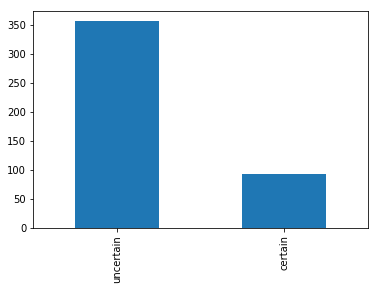

In [23]:
df['decision'].value_counts().plot(kind='bar')

In [24]:
dataroot = 'NEU-CLS_New/val'
val_dataset = datasets.ImageFolder(dataroot, data_transforms['val'])
dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

model_ft = model_ft.eval()
running_corrects = 0.0
total = 0.0
for input_tensor, target in dataloader:
    input_tensor = input_tensor.cuda()
    target = target.cuda()
    output = model_ft(input_tensor)
    preds = torch.max(output, 1)[1]
    correct = torch.sum(preds == target.data)
    running_corrects += correct
    total += input_tensor.shape[0]
    print("running corrects: {}/{}".format(correct, input_tensor.shape[0]))
    
print("Total corrects: {}/{}".format(running_corrects, total))

running corrects: 122/128
running corrects: 117/128
running corrects: 111/128
running corrects: 19/66
Total corrects: 369/450.0


In [31]:
df = df.sort_values(by=['score'], ascending=True)
img_paths = df['img_path'].tolist()
topk_indices = df['topk_idx'].tolist()
pred_indices = [idx[0] for idx in topk_indices]
class_to_idx = {'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'Rs': 4, 'SC': 5}
target_indices = []
for item in img_paths:
    target_cls = item.split('/')[-2].strip()
    target_idx = class_to_idx[target_cls]
    target_indices.append(target_idx)

In [41]:
df.head(50)

,c2c,decision,img_path,inclination,p_c1,p_c2,pred,score,topk_idx,topk_logits,topk_prob
379,87.585915,uncertain,NEU-CLS_New/val/In/In_35.bmp,"(50, 1, 5)",15.108217,15.111067,NA,0.001425,"[1, 5]","[8.382081, 5.00919]","[0.9652716, 0.033099514]"
439,87.585915,uncertain,NEU-CLS_New/val/In/In_9.bmp,"(50, 1, 5)",10.373792,10.381591,NA,0.003898,"[1, 5]","[5.698078, 2.6433673]","[0.94933987, 0.044748414]"
417,87.585915,uncertain,NEU-CLS_New/val/In/In_7.bmp,"(50, 1, 5)",11.182829,11.191539,NA,0.004352,"[1, 5]","[6.052051, 2.9456294]","[0.9529175, 0.042653386]"
8,92.447060,uncertain,NEU-CLS_New/val/SC/Sc_39.bmp,"(50, 1, 2)",14.037254,14.046900,NA,0.004573,"[1, 2]","[4.78803, 3.565062]","[0.7258267, 0.21365084]"
0,87.585915,uncertain,NEU-CLS_New/val/SC/Sc_31.bmp,"(50, 1, 5)",9.945909,9.981851,NA,0.017963,"[1, 5]","[6.191887, 3.5377743]","[0.92998606, 0.06543498]"
435,87.585915,uncertain,NEU-CLS_New/val/In/In_86.bmp,"(50, 1, 5)",13.464128,13.501913,NA,0.018883,"[1, 5]","[6.732733, 3.0222564]","[0.9668159, 0.023653984]"
38,92.447060,uncertain,NEU-CLS_New/val/SC/Sc_66.bmp,"(50, 1, 2)",14.164417,14.207881,NA,0.021728,"[1, 2]","[3.7750115, 2.7096875]","[0.6700898, 0.23092376]"
428,87.585915,uncertain,NEU-CLS_New/val/In/In_8.bmp,"(50, 1, 5)",12.390463,12.467583,NA,0.038473,"[1, 5]","[5.8438144, 2.26458]","[0.9657229, 0.026940819]"
337,92.447060,uncertain,NEU-CLS_New/val/PS/PS_65.bmp,"(50, 2, 1)",31.554132,31.636000,NA,0.040908,"[2, 1]","[9.888131, 5.8107276]","[0.9832654, 0.016667746]"
404,87.585915,uncertain,NEU-CLS_New/val/In/In_58.bmp,"(50, 1, 5)",13.151902,13.260269,NA,0.054130,"[1, 5]","[7.4356155, 4.021686]","[0.96542346, 0.031773653]"


#### Validation Check
##### We observe the signal visualization for the miss-classified examples.
##### Following are the top-30 miss-classified images

In [39]:
top_target_indices = target_indices[:30]
top_pred_indices = pred_indices[:30]
for index, (a,b) in enumerate(zip(top_target_indices, top_pred_indices)):
    if(a!=b):
        print(index, a, b)

3 5 1
4 5 1
6 5 1
11 5 1
12 5 2
17 5 2
18 5 1
23 5 1
26 5 2
28 5 1
29 5 2
32 5 1
33 5 2
39 5 1
41 2 1
44 5 1
46 0 3
53 5 1
57 2 1
58 5 1
60 5 2
61 5 1
65 5 1
66 5 1
67 5 1
68 5 1
69 5 1
75 5 2
79 5 1
